In [1]:
import os.path

import torch
from torch import nn, optim

import numpy as np

% matplotlib inline
import matplotlib.pyplot as plt

from mnist_cnn import *
from utils import *

from scipy import stats
from scipy.spatial.distance import cosine

In [2]:
DISABLE_CUDA = False

if not DISABLE_CUDA and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
dataset = MNIST(
    os.path.join(*'data/MNIST'.split('/')),
    batch_size=32, val_size=.2
)

In [4]:
model = load_model(mnist_model(), os.path.join('models', 'mnist.pt'), device)

model.eval()
test_accuracy = 0

with torch.no_grad():
    for X, y, label in dataset.test_loader:
        X = X.to(device); y = y.to(device)

        pred = model(X)
        test_accuracy += (torch.argmax(pred, 1) == y).sum()

test_accuracy = test_accuracy.item() / dataset.test_size

print('Test accuracy: %.3f' % test_accuracy)
print('Test error rate: %.3f' % (1 - test_accuracy))

Test accuracy: 0.993
Test error rate: 0.007


In [5]:
emb_dim = 100

vae = ConvVAE(emb_dim).to(device)
model_path = os.path.join('models', 'conv_vae_mnist.pt')
vae.load_state_dict(torch.load(model_path))

vae = vae.eval()

First, we will find that image closest to an original image, belonging to its second most probable class.

Similarity between image will be computed with the cosine distance at the VAE embedding level.

In [6]:
def find_other(self_embedding, other_embeddings, distance=cosine):
    self_embedding = self_embedding.cpu().detach().numpy()
    other_embeddings = other_embeddings.cpu().detach().numpy()
    
    dists = np.array([
        distance(self_embedding, other_embedding)
        for other_embedding in other_embeddings
    ])
    
    return np.argmin(dists)

In [7]:
X = torch.stack([
    dataset[idx][0]
    for idx in dataset.train
]).to(device)

with torch.no_grad():
    embeddings = vae.encode(X)[0]

In [8]:
train_labels = dataset.labels[dataset.train]

train_by_labels = [
    dataset.train[train_labels == other_label]
    for other_label in range(dataset.num_classes)
]

In [9]:
idx_to_train = {
    idx: i
    for i, idx in enumerate(dataset.train)
}

In [10]:
embeddings_by_labels = [
    embeddings[
        torch.from_numpy((train_labels == other_label).astype(int)).nonzero().squeeze()
    ]
    for other_label in range(dataset.num_classes)
]

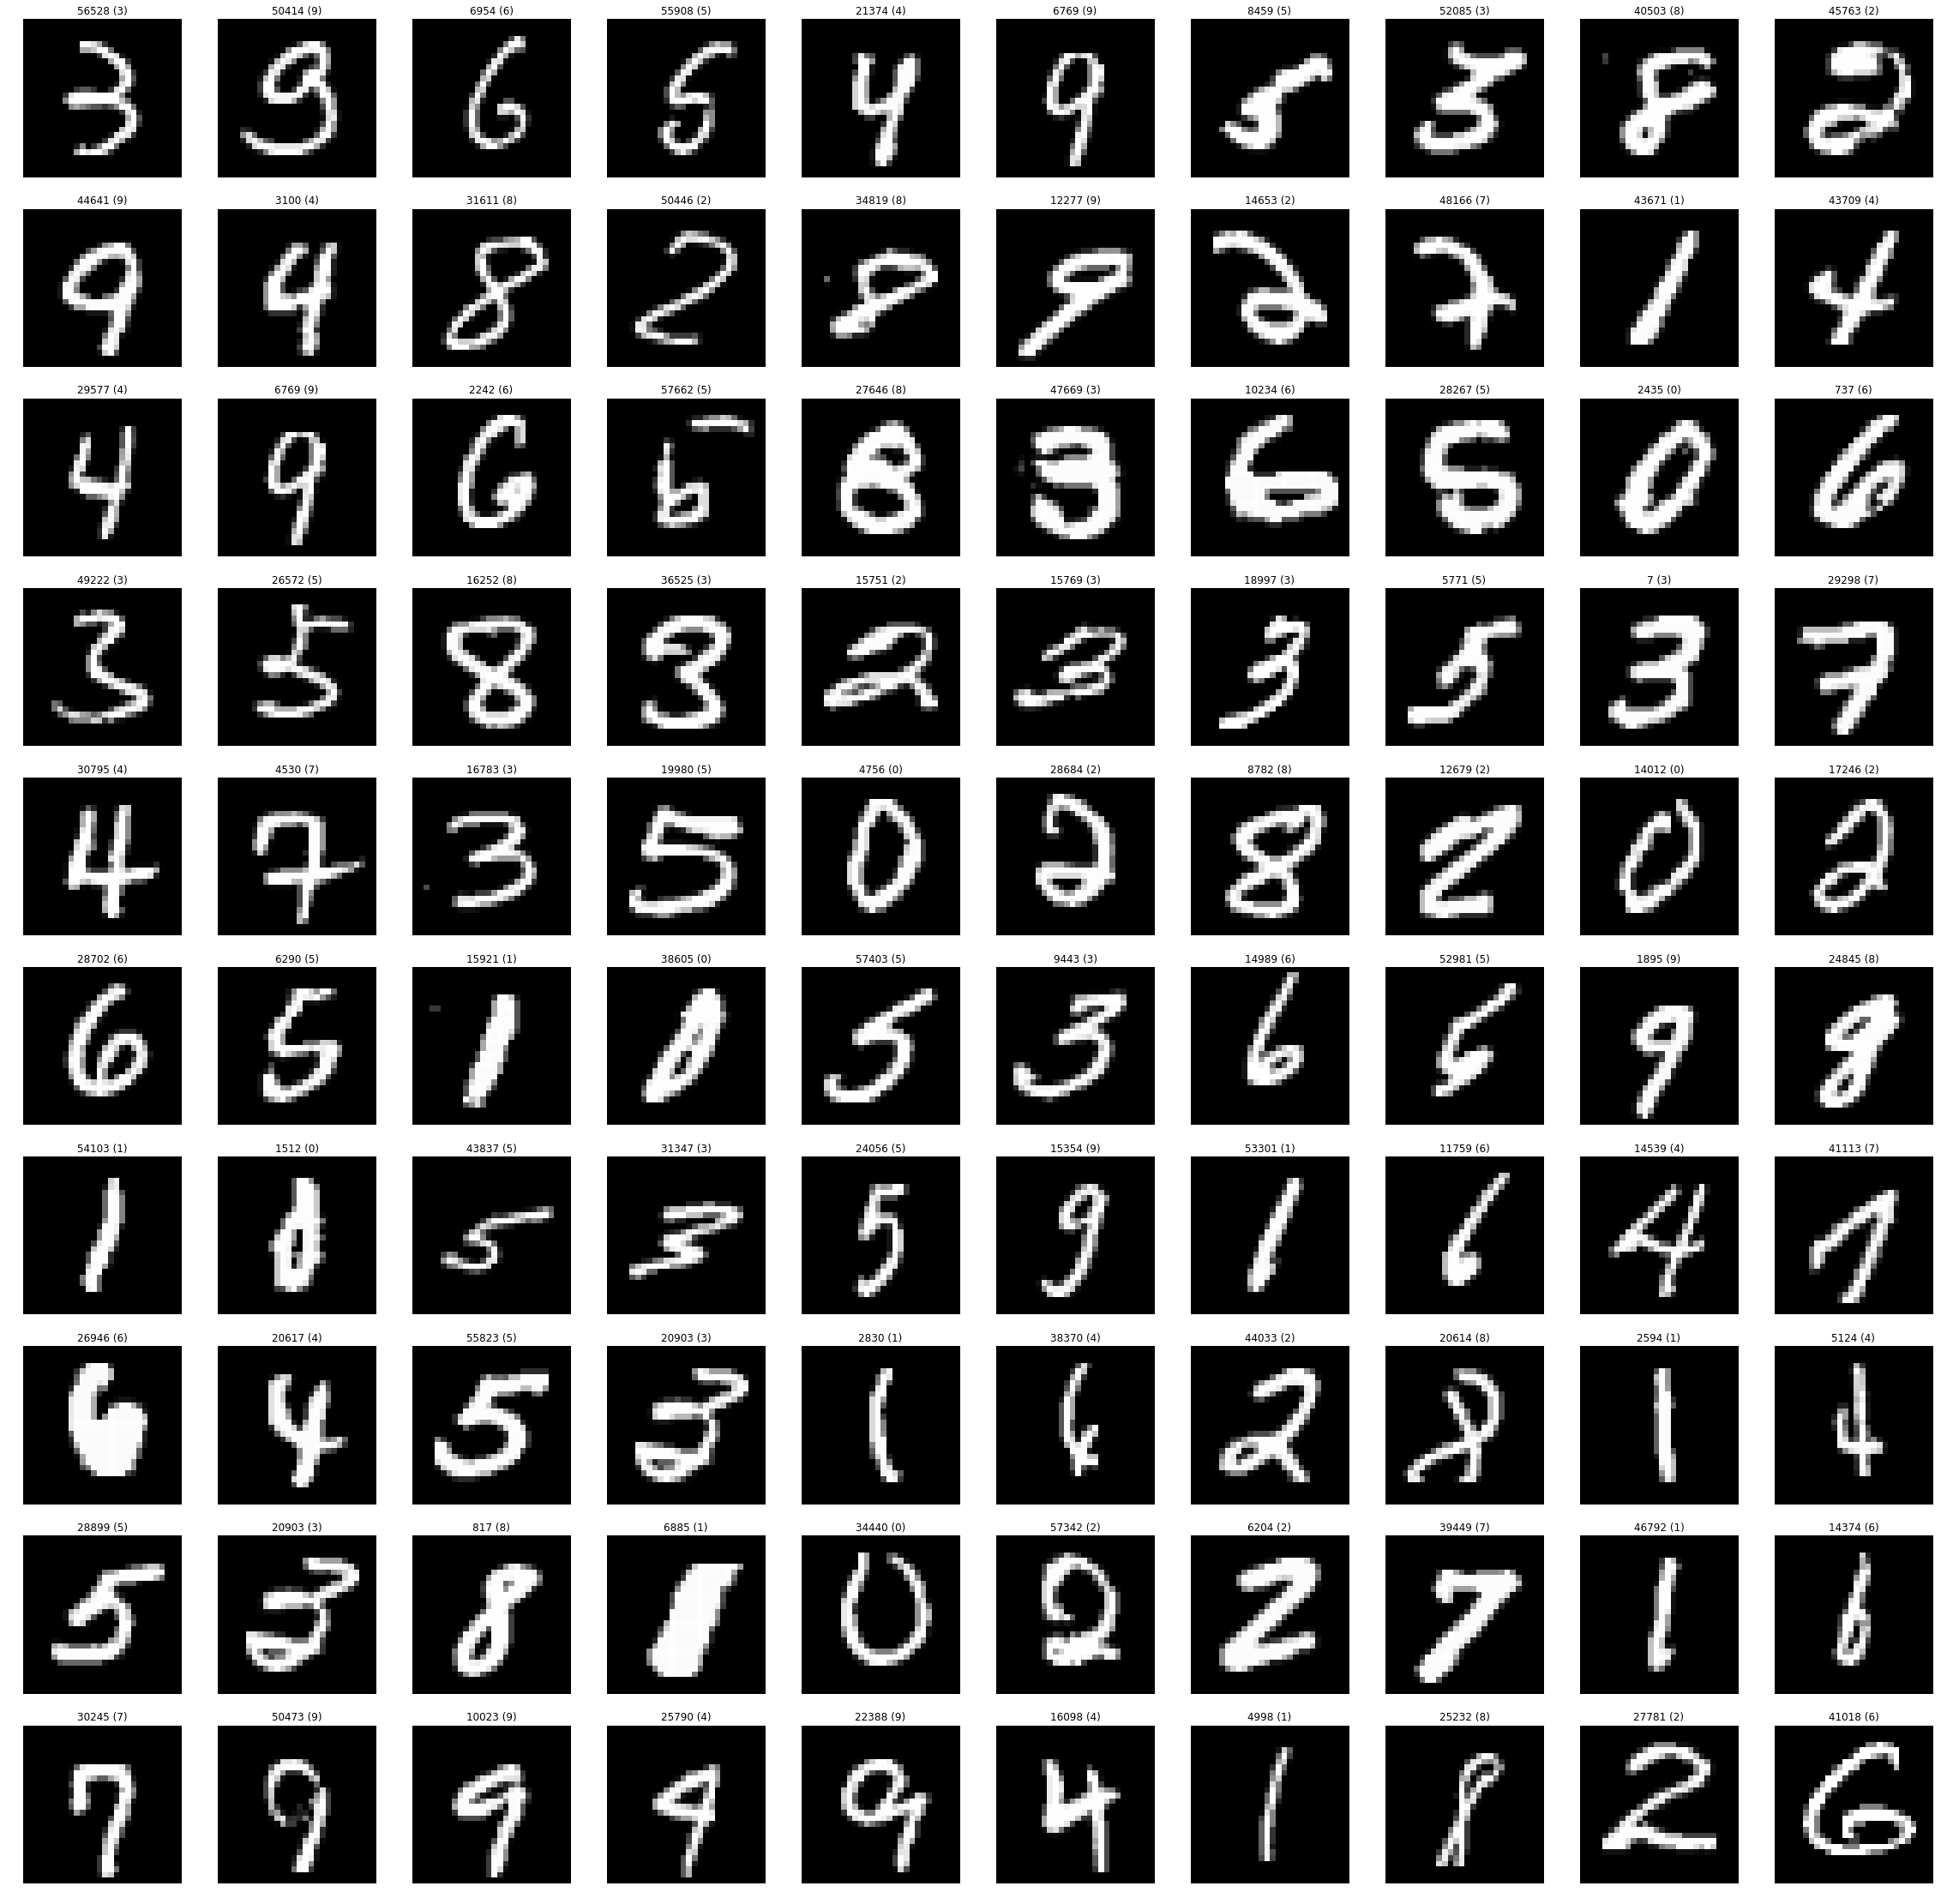

In [15]:
axes_mat = subplots(10, 10).reshape(50, 2)
idxs = np.random.choice(dataset.train, len(axes_mat), replace=False)

for axes, idx in zip(axes_mat, idxs):
    img, label, _ = dataset[idx]
    
    other_label = model(img.unsqueeze(0).to(device))[0].sort()[1][-2]
    other_idxs = train_by_labels[other_label]
    self_embedding, other_embeddings = \
        embeddings[idx_to_train[idx]], embeddings_by_labels[other_label]
    
    other_idx = find_other(self_embedding, other_embeddings)
    other_idx = other_idxs[other_idx]
    
    imshow(img, axes[0], title='%d (%d)' % (idx, label))
    imshow(dataset[other_idx][0], axes[1], title='%d (%d)' % (other_idx, other_label))

In [11]:
def get_path(other, self, path_length=100):
    return torch.stack([
        torch.sqrt(1 - alpha) * other + torch.sqrt(alpha) * self
        for alpha in torch.linspace(0, 1, path_length)
    ])

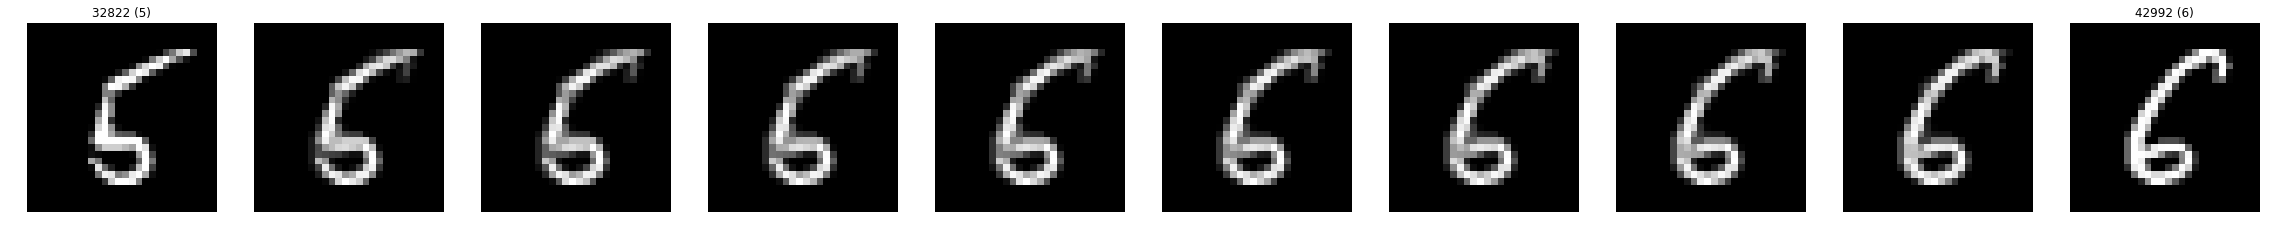

In [19]:
idx = 42992 # 6
self, self_label, _ = dataset[idx]
other_label = model(self.unsqueeze(0).to(device))[0].sort()[1][-2]
other_idxs = train_by_labels[other_label]
self_embedding, other_embeddings = \
    embeddings[idx_to_train[idx]], embeddings_by_labels[other_label]

other_idx = find_other(self_embedding, other_embeddings)
other_idx = other_idxs[other_idx]
other = dataset[other_idx][0]

path = get_path(other, self, path_length=10)
axes = subplots(1, 10)

for ax, img in zip(axes, path):
    imshow(img, ax)

axes[0].set_title('%d (%d)' % (other_idx, other_label))
axes[-1].set_title('%d (%d)' % (idx, self_label));

In [20]:
window_z = 1.96

path = get_path(other, self, path_length=100)
path = path.to(device).detach().requires_grad_()

path_pred = model(path)
path_ps = F.softmax(path_pred[:, [other_label, self_label]], dim=1)
path_ps[:, 1].sum().backward() # obtain gradient of self_label along path

path_entropy = -(path_ps * torch.log2(path_ps)).sum(dim=1)
path_entropy = path_entropy.cpu().detach().numpy()

entropy_mean = (path_entropy * np.arange(len(path))).sum() / path_entropy.sum()

entropy_std = np.sqrt(
    (path_entropy * (np.arange(len(path)) - entropy_mean) ** 2).sum() / path_entropy.sum()
)

half_window = entropy_std * window_z
window = (
    max(0, entropy_mean - half_window),
    min(len(path) - 1, entropy_mean + half_window)
)

gradients_per_pixel = path.grad.view(len(path), -1).cpu().detach().numpy()

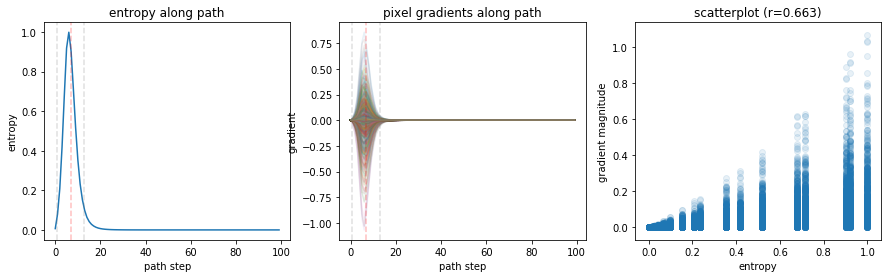

In [42]:
ax_entropy, ax_gradient, ax_scatter = subplots(1, 3, figsize=(15, 4))

ax_entropy.plot(path_entropy)
ax_entropy.axvline(entropy_mean, linestyle='dashed', color='red', alpha=.25)
ax_entropy.axvline(window[0], linestyle='dashed', color='gray', alpha=.25)
ax_entropy.axvline(window[1], linestyle='dashed', color='gray', alpha=.25)
ax_entropy.set_xlabel('path step')
ax_entropy.set_ylabel('entropy')
ax_entropy.set_title('entropy along path')

ax_gradient.plot(gradients_per_pixel, alpha=.1);
ax_gradient.axvline(entropy_mean, linestyle='dashed', color='red', alpha=.25)
ax_gradient.axvline(window[0], linestyle='dashed', color='gray', alpha=.25)
ax_gradient.axvline(window[1], linestyle='dashed', color='gray', alpha=.25)
ax_gradient.set_xlabel('path step')
ax_gradient.set_ylabel('gradient')
ax_gradient.set_title('pixel gradients along path')

ax_scatter.scatter(
    path_entropy.repeat(gradients_per_pixel.shape[1]), 
    np.abs(gradients_per_pixel).flatten(),
    alpha=.1
)
ax_scatter.set_xlabel('entropy')
ax_scatter.set_ylabel('gradient magnitude')
ax_scatter.set_title('scatterplot (r=%.3f)' % stats.pearsonr(
    path_entropy.repeat(gradients_per_pixel.shape[1]), 
    np.abs(gradients_per_pixel).flatten()
)[0]);

In [42]:
samples = np.random.choice(dataset.train, 1000, replace=False)

entropies, entropy_means, gradients, windows = [], [], [], []

for idx in samples:
    self, self_label, _ = dataset[idx]
    other_label = model(self.unsqueeze(0).to(device))[0].sort()[1][-2]
    other_idxs = train_by_labels[other_label]
    self_embedding, other_embeddings = \
        embeddings[idx_to_train[idx]], embeddings_by_labels[other_label]

    other_idx = find_other(self_embedding, other_embeddings)
    other_idx = other_idxs[other_idx]
    other = dataset[other_idx][0]
    
    window_z = 1.96

    path = get_path(other, self, path_length=100)
    path = path.to(device).detach().requires_grad_()

    path_pred = model(path)
    path_ps = F.softmax(path_pred[:, [other_label, self_label]], dim=1)
    path_ps[:, 1].sum().backward() # obtain gradient of self_label along path

    path_entropy = -(path_ps * torch.log2(path_ps)).sum(dim=1)
    path_entropy = path_entropy.cpu().detach().numpy()
    
    entropy_mean = (path_entropy * np.arange(len(path))).sum() / path_entropy.sum()
    entropy_means.append(entropy_mean)

    entropy_std = np.sqrt(
        (path_entropy * (np.arange(len(path)) - entropy_mean) ** 2).sum() / path_entropy.sum()
    )

    half_window = entropy_std * window_z
    window = (
        max(0, entropy_mean - half_window),
        min(len(path) - 1, entropy_mean + half_window)
    )
    windows.append(window)

    gradients_per_pixel = path.grad.view(len(path), -1).cpu().detach().numpy()
    
    entropies.append(path_entropy)
    gradients.append(gradients_per_pixel)
    
stats.pearsonr(
    np.concatenate(entropies).repeat(gradients_per_pixel.shape[1]), 
    np.abs(np.concatenate(gradients)).flatten()
)[0]

0.5931528

In [43]:
left = np.array([w[0] == 0 for w in windows])
right = np.array([w[1] == (len(path) - 1) for w in windows])
middle = np.array([not l and not r for l, r in zip(left, right)])

In [44]:
left.any(), right.any(), middle.any()

(True, True, True)

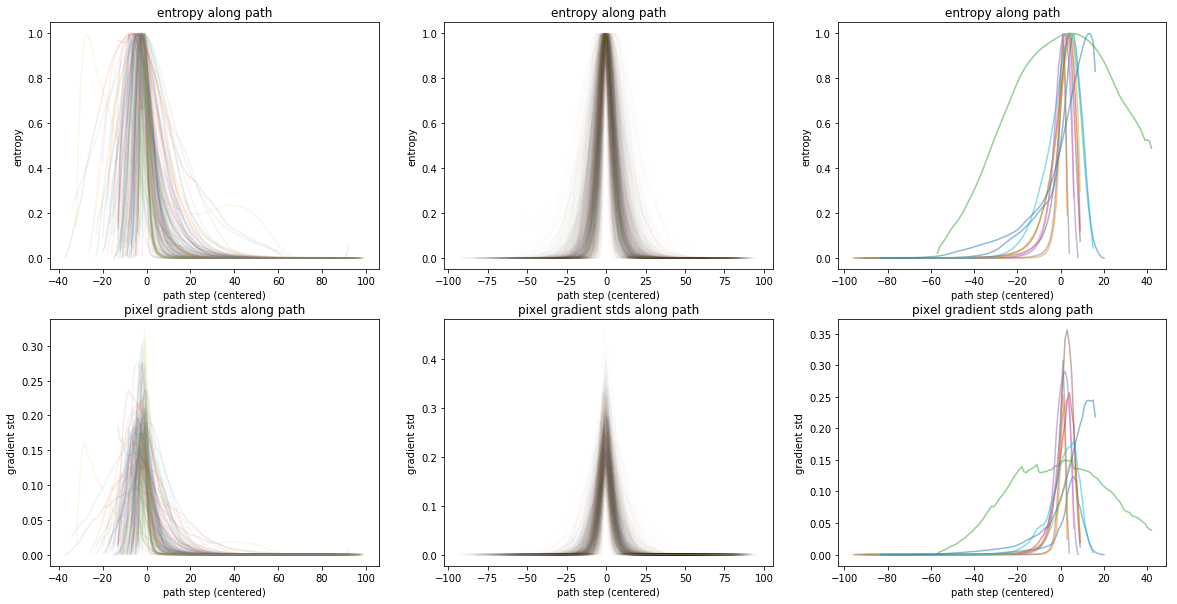

In [46]:
axes_mat = subplots(2, 3, figsize=(20, 10))

for (ax_entropy, ax_gradient), subset, alpha in zip(axes_mat.T, [left, middle, right], [.1, .01, .5]):    
    xs = np.stack([
        np.arange(-m, len(path) - m)
        for m in np.round(np.array(entropy_means)[subset])
    ])
    
    for x, e in zip(xs, np.stack(entropies)[subset]):
        ax_entropy.plot(x, e, alpha=alpha)
        
    ax_entropy.set_xlabel('path step (centered)')
    ax_entropy.set_ylabel('entropy')
    ax_entropy.set_title('entropy along path')
    
    gs = np.stack(gradients)[subset]
        
    for x, g in zip(xs, gs):
        ax_gradient.plot(x, g.std(axis=1), alpha=alpha)
            
    ax_gradient.set_xlabel('path step (centered)')
    ax_gradient.set_ylabel('gradient std')
    ax_gradient.set_title('pixel gradient stds along path')

# Linear vs. Radial Interpolation

In [15]:
x1, x2 = np.random.choice(dataset.train, size=1000 * 2, replace=False).reshape(2, 1000)
x1 = embeddings[[idx_to_train[i] for i in x1]].cpu().numpy()
x2 = embeddings[[idx_to_train[i] for i in x2]].cpu().numpy()

linear_interpolation_paths = np.stack([
    (1 - alpha) * x1 + alpha * x2
    for alpha in np.linspace(0, 1, 50)
], axis=-1)

radial_interpolation_paths = np.stack([
    np.sqrt(1 - alpha) * x1 + np.sqrt(alpha) * x2
    for alpha in np.linspace(0, 1, 50)
], axis=-1)

li_norms = np.linalg.norm(linear_interpolation_paths, ord=2, axis=1)
ri_norms = np.linalg.norm(radial_interpolation_paths, ord=2, axis=1)

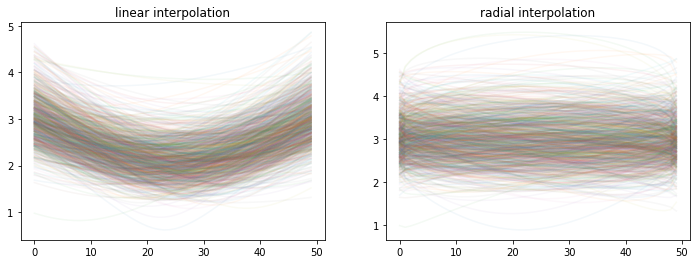

In [17]:
axes = subplots(1, 2, figsize=(12, 4))

axes[0].plot(li_norms.T, alpha=.05);
axes[0].set_title('linear interpolation')
axes[1].plot(ri_norms.T, alpha=.05);
axes[1].set_title('radial interpolation');